In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader, random_split

from torchvision import models
from torchvision.models import ResNet50_Weights
from torchvision.datasets import ImageFolder
from sklearn.metrics import precision_score, recall_score, f1_score



In [7]:
import kagglehub

# Download latest version
data = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

Using Colab cache for faster access to the 'skin-cancer-malignant-vs-benign' dataset.


In [9]:
print(os.listdir(data))

['data', 'test', 'train']


In [10]:
train_transform = T.Compose([
    T.Resize(232),
    T.CenterCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

valid_transform = T.Compose([
    T.Resize(232),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [12]:
train_ds = ImageFolder(root=f"{data}/train", transform=train_transform)
valid_ds = ImageFolder(root=f"{data}/test", transform=valid_transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=128, shuffle=False)

In [13]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


In [14]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=2048, out_features=2)

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

In [15]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
def fit(model, n_epochs, device = "cuda" if torch.cuda.is_available() else "cpu"):
    tr_loss, vl_loss = [], []
    tr_acc, vl_acc = [], []
    tr_prec, vl_prec = [], []
    tr_rec, vl_rec = [], []
    tr_f1, vl_f1 = [], []

    model.to(device)

    for n in range(n_epochs):
        model.train()
        tr_loss_iter = []
        all_preds, all_labels = [], []

        for samples, labels in train_loader:
            samples, labels = samples.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(samples)  # [batch_size, 2]
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            tr_loss_iter.append(loss.item())

            pred_classes = preds.argmax(dim=1)  # выбираем класс с большим логитом
            all_preds.append(pred_classes.cpu())
            all_labels.append(labels.cpu())

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        tr_loss.append(np.mean(tr_loss_iter))
        tr_acc.append((all_preds == all_labels).sum().item() / len(all_labels))
        tr_prec.append(precision_score(all_labels, all_preds, average='binary'))
        tr_rec.append(recall_score(all_labels, all_preds, average='binary'))
        tr_f1.append(f1_score(all_labels, all_preds, average='binary'))

        model.eval()
        vl_loss_iter = []
        all_preds, all_labels = [], []

        with torch.no_grad():
            for samples, labels in valid_loader:
                samples, labels = samples.to(device), labels.to(device)
                preds = model(samples)
                loss = criterion(preds, labels)
                vl_loss_iter.append(loss.item())

                pred_classes = preds.argmax(dim=1)
                all_preds.append(pred_classes.cpu())
                all_labels.append(labels.cpu())

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        vl_loss.append(np.mean(vl_loss_iter))
        vl_acc.append((all_preds == all_labels).sum().item() / len(all_labels))
        vl_prec.append(precision_score(all_labels, all_preds, average='binary'))
        vl_rec.append(recall_score(all_labels, all_preds, average='binary'))
        vl_f1.append(f1_score(all_labels, all_preds, average='binary'))

        print(f"Epoch {n+1}/{n_epochs}: "
              f"tr_loss={tr_loss[-1]:.3f}, vl_loss={vl_loss[-1]:.3f}, "
              f"tr_acc={tr_acc[-1]:.3f}, vl_acc={vl_acc[-1]:.3f}, "
              f"tr_f1={tr_f1[-1]:.3f}, vl_f1={vl_f1[-1]:.3f}")

    return tr_loss, vl_loss, tr_acc, vl_acc, tr_prec, vl_prec, tr_rec, vl_rec, tr_f1, vl_f1

In [19]:
tr_loss, vl_loss, tr_acc, vl_acc, tr_prec, vl_prec, tr_rec, vl_rec, tr_f1, vl_f1 = fit(model, 5)

Epoch 1/5: tr_loss=0.360, vl_loss=0.365, tr_acc=0.822, vl_acc=0.862, tr_f1=0.809, vl_f1=0.828
Epoch 2/5: tr_loss=0.208, vl_loss=0.269, tr_acc=0.908, vl_acc=0.892, tr_f1=0.896, vl_f1=0.882
Epoch 3/5: tr_loss=0.147, vl_loss=0.282, tr_acc=0.937, vl_acc=0.900, tr_f1=0.932, vl_f1=0.891
Epoch 4/5: tr_loss=0.110, vl_loss=0.273, tr_acc=0.956, vl_acc=0.892, tr_f1=0.952, vl_f1=0.884
Epoch 5/5: tr_loss=0.075, vl_loss=0.324, tr_acc=0.971, vl_acc=0.898, tr_f1=0.968, vl_f1=0.892


In [20]:
def plot_metrics(tr_loss, vl_loss, tr_acc, vl_acc,
                 tr_prec, vl_prec, tr_rec, vl_rec,
                 tr_f1, vl_f1):

    epochs = range(1, len(tr_loss) + 1)

    plt.figure(figsize=(18, 12))

    # Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, tr_loss, label='Train Loss')
    plt.plot(epochs, vl_loss, label='Valid Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, tr_acc, label='Train Acc')
    plt.plot(epochs, vl_acc, label='Valid Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, tr_prec, label='Train Precision')
    plt.plot(epochs, vl_prec, label='Valid Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    # Recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, tr_rec, label='Train Recall')
    plt.plot(epochs, vl_rec, label='Valid Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

    # F1-Score
    plt.subplot(2, 3, 5)
    plt.plot(epochs, tr_f1, label='Train F1')
    plt.plot(epochs, vl_f1, label='Valid F1')
    plt.title('F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

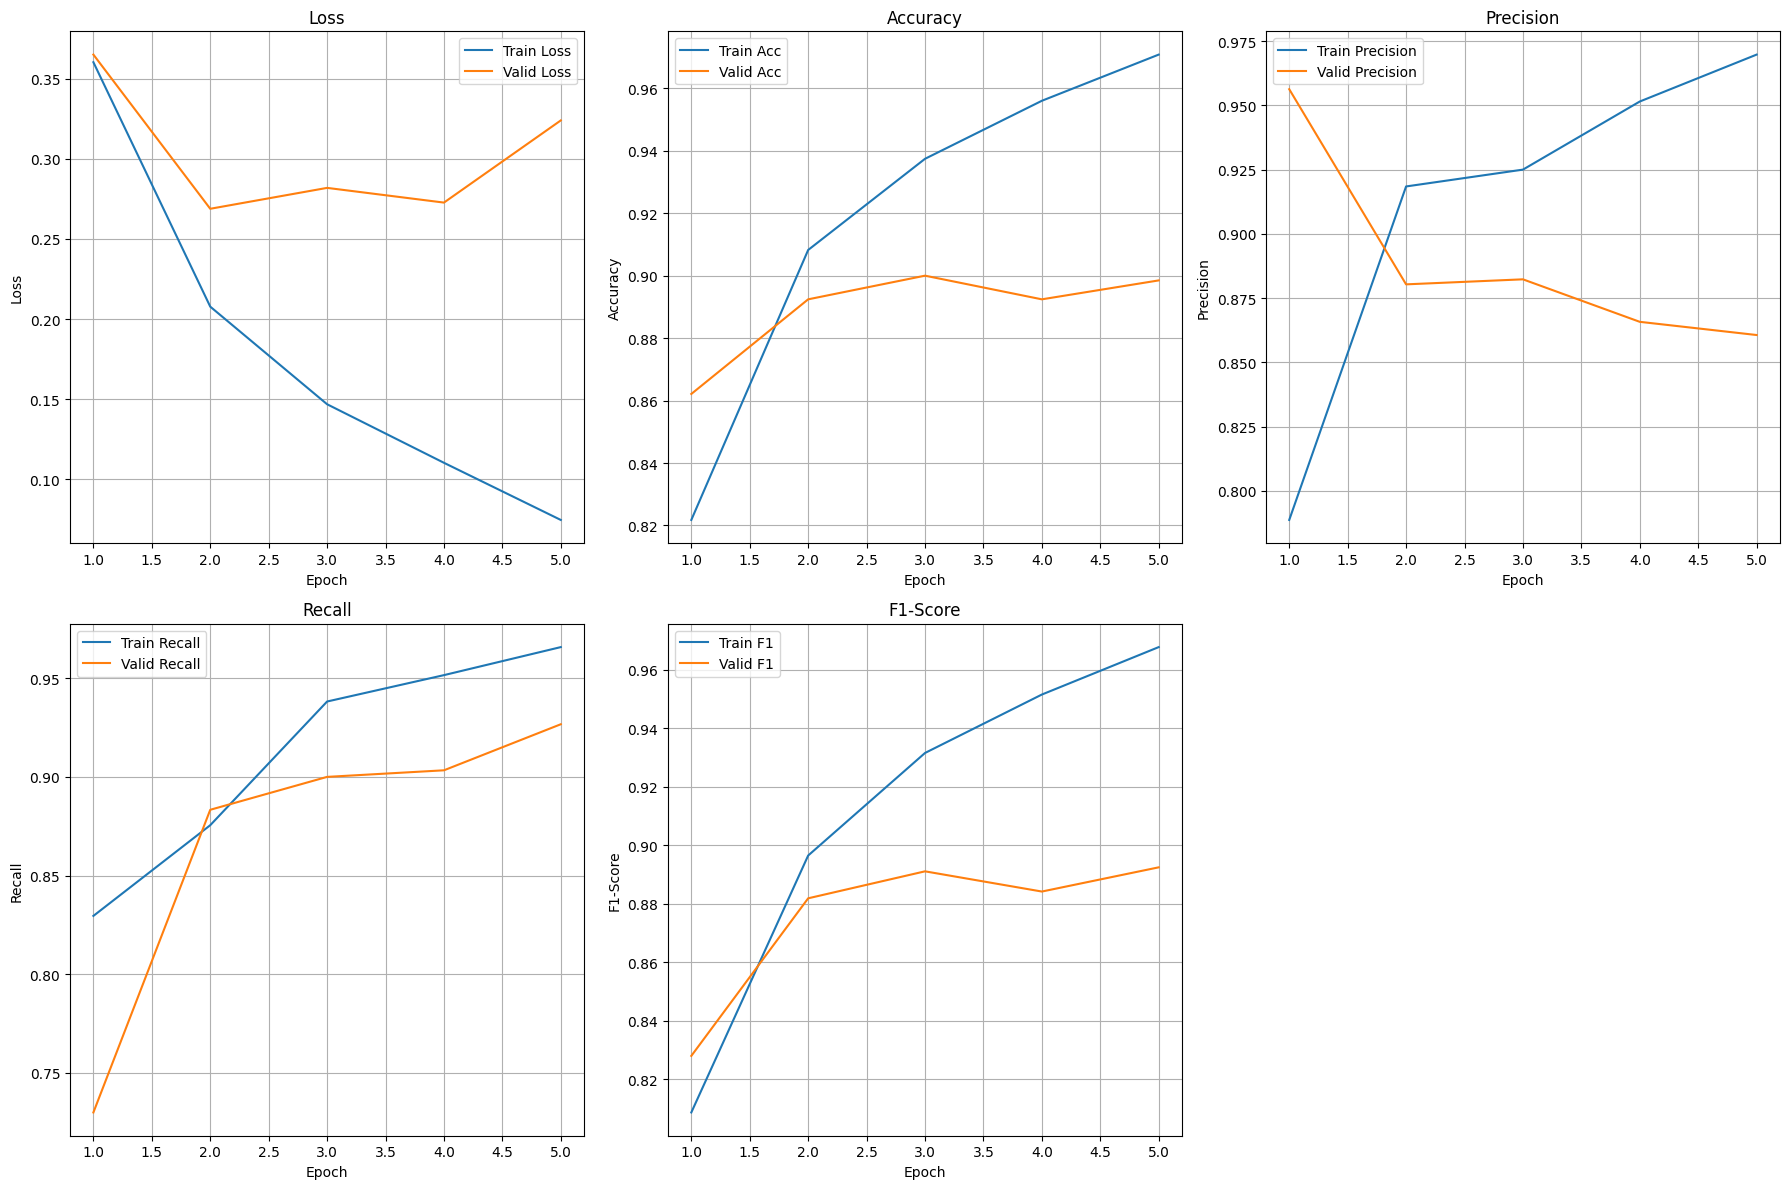

In [21]:
plot_metrics(tr_loss, vl_loss, tr_acc, vl_acc, tr_prec, vl_prec, tr_rec, vl_rec, tr_f1, vl_f1)